In [2]:
import datetime, time, os

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

import json
import pandas as pd
from pandas_profiling import ProfileReport

from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import plotly.graph_objects as go
# Create traces

import warnings
warnings.filterwarnings('ignore')

In [4]:

df = pd.read_csv("ane.energy/imbalance_de.csv", parse_dates=['dt_start_utc'], index_col='dt_start_utc')
'''
# Below is an example of getting the weekofyear
df =(
    df
    .assign(weekday = lambda df: df.index.weekday)
    .assign(month = lambda df: df.index.month)
    .assign(year = lambda df: df.index.year) 
);
'''

'\n# Below is an example of getting the weekofyear\ndf =(\n    df\n    .assign(weekday = lambda df: df.index.weekday)\n    .assign(month = lambda df: df.index.month)\n    .assign(year = lambda df: df.index.year) \n);\n'

In [5]:
df['rebap_eur_mwh'].argmax()

133038

In [6]:
#cols = df["year"].unique()
#cols = cols.tolist()
#df = df[df["year"]!=2013]

## Data Cleaning

In [7]:
df.head()

,rz_saldo_mwh,rebap_eur_mwh
dt_start_utc,,
2013-12-31 23:00:00,707.500,156.36
2013-12-31 23:15:00,966.296,81.23
2013-12-31 23:30:00,1018.984,104.01
2013-12-31 23:45:00,867.940,60.51
2014-01-01 00:00:00,1738.004,239.03


In [8]:
count_nan = np.isnan(df["rebap_eur_mwh"]).values.sum()

## Feature Engineering

In [9]:
df["diff_reb"] = df["rebap_eur_mwh"]-df["rebap_eur_mwh"].shift()
df["diff_rz_saldo_mwh"] = df["rz_saldo_mwh"]-df["rz_saldo_mwh"].shift()

In [10]:
df["voality_rebap"] = (df["rebap_eur_mwh"]-df["rebap_eur_mwh"].shift())/df["rebap_eur_mwh"].shift().abs()
df["voality_rz_saldo_mwh"] = (df["rz_saldo_mwh"]-df["rz_saldo_mwh"].shift())/df["rz_saldo_mwh"].shift().abs()

In [11]:
df["voality_rebap_abs"] =df["voality_rebap"].abs()

In [12]:
df["volume_eur"] = df["rz_saldo_mwh"]*df["rebap_eur_mwh"]

In [13]:
cols = df.columns

In [14]:
df.head()

,rz_saldo_mwh,rebap_eur_mwh,diff_reb,diff_rz_saldo_mwh,voality_rebap,voality_rz_saldo_mwh,voality_rebap_abs,volume_eur
dt_start_utc,,,,,,,,
2013-12-31 23:00:00,707.500,156.36,NaN,NaN,NaN,NaN,NaN,110624.70000
2013-12-31 23:15:00,966.296,81.23,-75.13,258.796,-0.480494,0.365789,0.480494,78492.22408
2013-12-31 23:30:00,1018.984,104.01,22.78,52.688,0.280438,0.054526,0.280438,105984.52584
2013-12-31 23:45:00,867.940,60.51,-43.50,-151.044,-0.418229,-0.148230,0.418229,52519.04940
2014-01-01 00:00:00,1738.004,239.03,178.52,870.064,2.950256,1.002447,2.950256,415435.09612


In [15]:
#df[np.isnan(df["voality"])]

In [16]:
#df[np.isinf(df["voality"])]

In [17]:
#count_nan = np.isnan(df["voality"]).values.sum()
#count_inf = np.isinf(df["voality"]).values.sum()
#print("It contains " + str(count_inf) + " infinite values and " + str(count_nan) + " NaN values.")

In [18]:
#df["voality"].replace([np.inf, -np.inf], np.nan, inplace=True)
#df["voality"].fillna(df["voality"].mean(), inplace=True)

In [19]:
#count_nan = np.isnan(df["voality"]).values.sum()
#count_inf = np.isinf(df["voality"]).values.sum()
#print("It contains " + str(count_inf) + " infinite values and " + str(count_nan) + " NaN values.")

In [20]:
#df.head()

In [21]:
#bins = [-np.inf, -10, -5, -2, -1, -0.5, -0.15, 0.15, 0.5, 1, 2, 5, 10, np.inf]
#df['voality_bins'] = pd.cut(df['voality'], bins)
#df.head(20)

In [22]:
df.fillna(df.mean(), inplace=True)

In [23]:
df.to_csv('df_imbalanced_fe.csv')  

## Shift Correlation

In [24]:
cols = df.columns
cols=cols.tolist()
cols.remove("rebap_eur_mwh")

In [25]:
df.head()

,rz_saldo_mwh,rebap_eur_mwh,diff_reb,diff_rz_saldo_mwh,voality_rebap,voality_rz_saldo_mwh,voality_rebap_abs,volume_eur
dt_start_utc,,,,,,,,
2013-12-31 23:00:00,707.500,156.36,-0.000331,0.001327,NaN,NaN,inf,110624.70000
2013-12-31 23:15:00,966.296,81.23,-75.130000,258.796000,-0.480494,0.365789,0.480494,78492.22408
2013-12-31 23:30:00,1018.984,104.01,22.780000,52.688000,0.280438,0.054526,0.280438,105984.52584
2013-12-31 23:45:00,867.940,60.51,-43.500000,-151.044000,-0.418229,-0.148230,0.418229,52519.04940
2014-01-01 00:00:00,1738.004,239.03,178.520000,870.064000,2.950256,1.002447,2.950256,415435.09612


In [26]:
for i in cols:
    df[i] = df[i].shift(1)

In [27]:
df.head()

,rz_saldo_mwh,rebap_eur_mwh,diff_reb,diff_rz_saldo_mwh,voality_rebap,voality_rz_saldo_mwh,voality_rebap_abs,volume_eur
dt_start_utc,,,,,,,,
2013-12-31 23:00:00,NaN,156.36,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31 23:15:00,707.500,81.23,-0.000331,0.001327,NaN,NaN,inf,110624.70000
2013-12-31 23:30:00,966.296,104.01,-75.130000,258.796000,-0.480494,0.365789,0.480494,78492.22408
2013-12-31 23:45:00,1018.984,60.51,22.780000,52.688000,0.280438,0.054526,0.280438,105984.52584
2014-01-01 00:00:00,867.940,239.03,-43.500000,-151.044000,-0.418229,-0.148230,0.418229,52519.04940


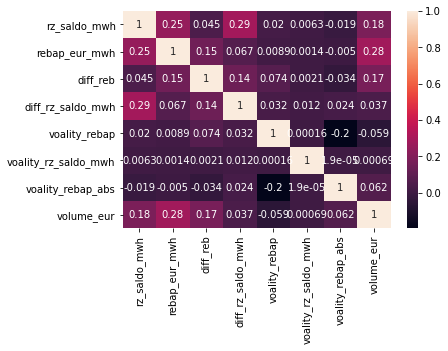

In [28]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [29]:
df['voality_bins'] = df['voality_bins'].astype(str)

KeyError: 'voality_bins'

In [ ]:
df_v_bins = df.groupby(df["voality_bins"]).count().reset_index()
df_v_bins.head(14)

In [ ]:
df.head()

# Voalität Visualisation

In [57]:
df_year_mean = df["voality_rebap"].groupby(df.index.year).median().reset_index()
df_year_mean = df_year_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_year_q1 = df["voality_rebap"].groupby(df.index.year).quantile(q=0.05).reset_index()
df_year_q1 = df_year_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_year_q2 = df["voality_rebap"].groupby(df.index.year).quantile(q=0.95).reset_index()
df_year_q2 = df_year_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_year_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_year_mean, df_year_q1, df_year_q2])
df_year_stats;

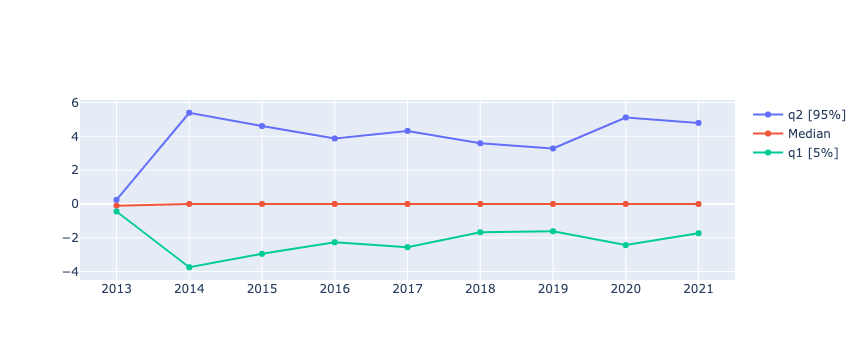

In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_year_stats["dt_start_utc"], y=df_year_stats["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_year_stats["dt_start_utc"], y=df_year_stats["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_year_stats["dt_start_utc"], y=df_year_stats["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))

fig.show()

## Months

In [59]:
df_month_mean = df["voality_rebap"].groupby(df.index.month).median().reset_index()
df_month_mean = df_month_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_month_q1 = df["voality_rebap"].groupby(df.index.month).quantile(q=0.05).reset_index()
df_month_q1 = df_month_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_month_q2 = df["voality_rebap"].groupby(df.index.month).quantile(q=0.95).reset_index()
df_month_q2 = df_month_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_month_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_month_mean, df_month_q1, df_month_q2])

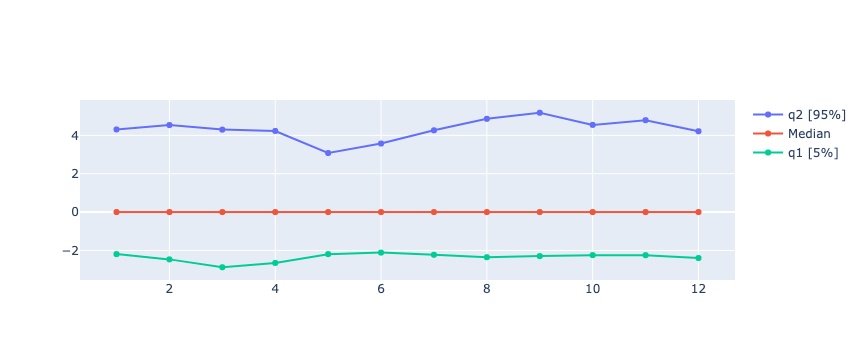

In [60]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_month_stats["dt_start_utc"], y=df_month_stats["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_month_stats["dt_start_utc"], y=df_month_stats["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_month_stats["dt_start_utc"], y=df_month_stats["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))


fig.show()

## Weekdays

In [61]:
df_weekday_mean = df["voality_rebap"].groupby(df.index.weekday).median().reset_index()
df_weekday_mean = df_weekday_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_weekday_q1 = df["voality_rebap"].groupby(df.index.weekday).quantile(q=0.95).reset_index()
df_weekday_q1 = df_weekday_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_weekday_q2 = df["voality_rebap"].groupby(df.index.weekday).quantile(q=0.05).reset_index()
df_weekday_q2 = df_weekday_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_weekday_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_weekday_mean, df_weekday_q1, df_weekday_q2])

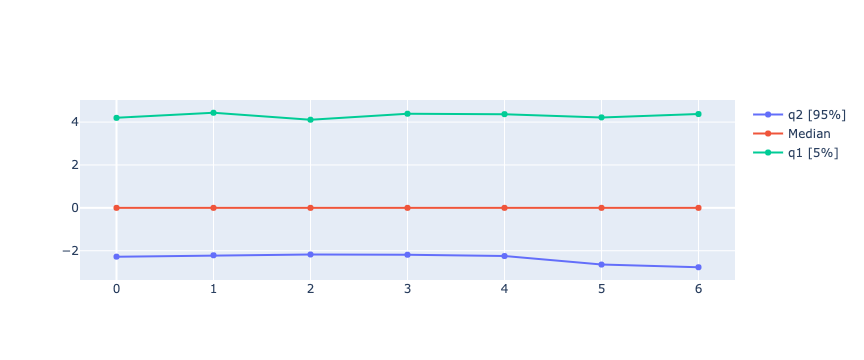

In [62]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_weekday_stats["dt_start_utc"], y=df_weekday_stats["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_weekday_stats["dt_start_utc"], y=df_weekday_stats["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_weekday_stats["dt_start_utc"], y=df_weekday_stats["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))


fig.show()

## Hours

In [63]:
df_hour_mean = df["voality_rebap"].groupby(df.index.hour).median().reset_index()
df_hour_mean = df_hour_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_hour_q1 = df["voality_rebap"].groupby(df.index.hour).quantile(q=0.05).reset_index()
df_hour_q1 = df_hour_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_hour_q2 = df["voality_rebap"].groupby(df.index.hour).quantile(q=0.95).reset_index()
df_hour_q2 = df_hour_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_hour_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_hour_mean, df_hour_q1, df_hour_q2])

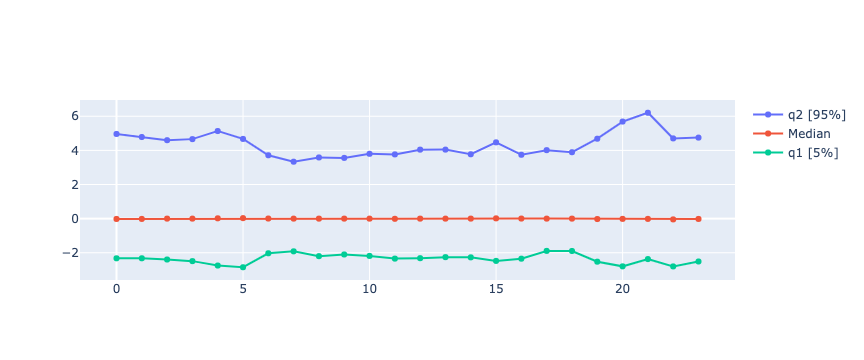

In [64]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hour_stats["dt_start_utc"], y=df_hour_stats["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_hour_stats["dt_start_utc"], y=df_hour_stats["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_hour_stats["dt_start_utc"], y=df_hour_stats["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))


fig.show()

## Business Days Hours

In [65]:
df_bd = df[df.index.dayofweek < 5]

df_bhour_mean = df[df.index.dayofweek < 5]["voality_rebap"].groupby(df[df.index.dayofweek < 5].index.hour).median().reset_index()
df_bhour_mean = df_bhour_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_bhour_q1 = df[df.index.dayofweek < 5]["voality_rebap"].groupby(df[df.index.dayofweek < 5].index.hour).quantile(q=0.05).reset_index()
df_bhour_q1 = df_bhour_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_bhour_q2 = df[df.index.dayofweek < 5]["voality_rebap"].groupby(df[df.index.dayofweek < 5].index.hour).quantile(q=0.95).reset_index()
df_bhour_q2 = df_bhour_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_bhour_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_bhour_mean, df_bhour_q1, df_bhour_q2])

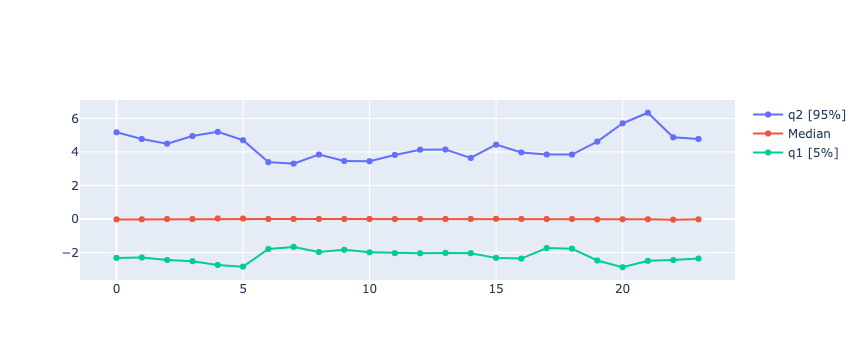

In [66]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))

fig.show()

## business day

In [67]:
m1 = df.index.dayofweek >= 0
m2 = df.index.dayofweek < 5
m3 = df.index.hour >= 5 
m4 = df.index.hour <= 18

df["businesshours"] = int(-1)
df['businesshours'] = df['businesshours'].mask(m1 & m2 & m3 & m4, '1')
df["businesshours"] = df["businesshours"].astype('int64')



In [68]:
df.dtypes

rz_saldo_mwh            float64
rebap_eur_mwh           float64
diff_reb                float64
diff_rz_saldo_mwh       float64
voality_rebap           float64
voality_rz_saldo_mwh    float64
voality_rebap_abs       float64
volume_eur              float64
businesshours             int64
dtype: object

In [69]:

#df['Col1'] = df['businesshours'].mask(m1 & m3, 'N')

In [70]:
df.to_csv("df_businesshours.csv")

In [71]:
df[(df.index.dayofweek >= 0) & (df.index.dayofweek < 5) & (df.index.hour > 5 )& (df.index.hour <= 18)].head()

,rz_saldo_mwh,rebap_eur_mwh,diff_reb,diff_rz_saldo_mwh,voality_rebap,voality_rz_saldo_mwh,voality_rebap_abs,volume_eur,businesshours
dt_start_utc,,,,,,,,,
2014-01-01 06:00:00,218.644,-53.16,3.22,-164.856,0.074537,-0.429872,0.074537,10149.45448,1
2014-01-01 06:15:00,-209.600,-18.73,-99.58,-428.244,-2.145196,-1.958636,2.145196,11142.33600,1
2014-01-01 06:30:00,-121.336,-19.22,34.43,88.264,0.647667,0.421107,0.647667,2272.62328,1
2014-01-01 06:45:00,-231.856,-22.83,-0.49,-110.520,-0.026161,-0.910859,0.026161,4456.27232,1
2014-01-01 07:00:00,-302.472,-195.16,-3.61,-70.616,-0.187825,-0.304568,0.187825,6905.43576,1


## Weekends

In [72]:
df_weeend = df[df.index.dayofweek > 4]

df_bhour_mean = df[df.index.dayofweek > 4]["voality_rebap"].groupby(df[df.index.dayofweek > 4].index.hour).median().reset_index()
df_bhour_mean = df_bhour_mean.rename({"voality_rebap": 'voality_median'}, axis=1)

df_bhour_q1 = df[df.index.dayofweek > 4]["voality_rebap"].groupby(df[df.index.dayofweek > 4].index.hour).quantile(q=0.05).reset_index()
df_bhour_q1 = df_bhour_q1.rename({"voality_rebap": 'voality_q1'}, axis=1)

df_bhour_q2 = df[df.index.dayofweek > 4]["voality_rebap"].groupby(df[df.index.dayofweek > 4].index.hour).quantile(q=0.95).reset_index()
df_bhour_q2 = df_bhour_q2.rename({"voality_rebap": 'voality_q2'}, axis=1)

df_bhour_stats = reduce(lambda  left,right: pd.merge(left, right, on=['dt_start_utc'],
                                            how='inner'), [df_bhour_mean, df_bhour_q1, df_bhour_q2])

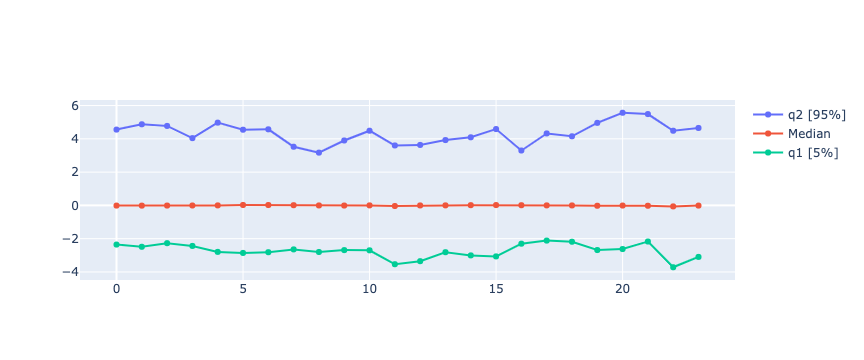

In [73]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_q2"],
                    mode='lines+markers', 
                    name='q2 [95%]'))

fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_median"],
                    mode='lines+markers',
                    name='Median'))

fig.add_trace(go.Scatter(x=df_bhour_stats ["dt_start_utc"], y=df_bhour_stats ["voality_q1"],
                    mode='lines+markers',
                    name='q1 [5%]' ))

fig.show()

## Histogramm

In [32]:
df_v_bins.head(10)

NameError: name 'df_v_bins' is not defined

In [33]:
import plotly.express as px
fig = px.histogram(df, x="voality_bins", category_orders=dict(voality_bins=[["(-inf, -10.0]", "(-10.0, -5.0]", 
                                                                            "(-5.0, -2.0]","(-2.0, -1.0]" ,
                                                                            "(-1.0, -0.5]","(-0.5, -0.15]",
                                                                            "(-0.15, 0.15]","(0.15, 0.5]",
                                                                            "(0.5, 1.0]","(1.0, 2.0]",
                                                                            "(2.0, 5.0]", "(5.0, 10.0]",
                                                                            "(10.0, inf]"]]))
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['rz_saldo_mwh', 'rebap_eur_mwh', 'diff_reb', 'diff_rz_saldo_mwh', 'voality_rebap', 'voality_rz_saldo_mwh', 'voality_rebap_abs', 'volume_eur'] but received: voality_bins